# Dynamically Expandable Network

Notebook brouillon

## Imports

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import logging as log
import re
import random
import collections
import time

import matplotlib.pyplot as plt
import numpy as np

## Chargement des datasets

Basé sur le code fourni dans [la documentation de PyTorch](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [2]:
# Conversion sortie torchvision en tenseur normalisé
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Affichage image dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [3]:
cifar10_train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cifar10_train_loader = torch.utils.data.DataLoader(cifar10_train_set, batch_size=4,
                                          shuffle=True, num_workers=2)

cifar10_test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
cifar10_test_loader = torch.utils.data.DataLoader(cifar10_test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

cifar10_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [25]:
mnist_train_set = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_set, batch_size=1,
                                          shuffle=True, num_workers=2)

mnist_test_set = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

mnist_classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

lsun_train_set = torchvision.datasets.PhotoTour(root='./data', train=True,
                                        download=True, transform=transform)
lsun_train_loader = torch.utils.data.DataLoader(stl10_train_set, batch_size=4,
                                          shuffle=True, num_workers=2)

lsun_test_set = torchvision.datasets.PhotoTour(root='./data', train=False,
                                       download=True, transform=transform)
lsun_test_loader = torch.utils.data.DataLoader(stl10_test_set, batch_size=4,
                                         shuffle=False, num_workers=2)

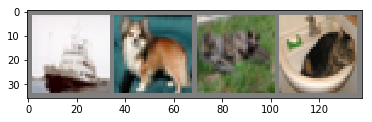

 ship   dog   cat   cat


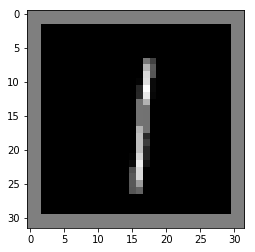

IndexError: index 1 is out of range for dimension 0 (of size 1)

In [26]:
# get some random training images
dataiter = iter(cifar10_train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()
# print labels
print(' '.join('%5s' % cifar10_classes[labels[j]] for j in range(4)))


# get some random training images
dataiter = iter(mnist_train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
plt.show()
# print labels
print(' '.join('%5s' % mnist_classes[labels[j]] for j in range(4)))

In [6]:
dataiter = iter(cifar10_train_loader)
images, labels = dataiter.next()
images[0].shape

torch.Size([3, 32, 32])

Process Process-6:
Process Process-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/anti/.anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anti/.anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/anti/.anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/.anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/anti/.anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 36, in _worker_loop
    r = index_queue.get()
  File "/home/anti/.anaconda3/lib/python3.6/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/home/anti/.anaconda3/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/

## Création des modèles baseline

Basé sur le code fourni dans [la documentation de PyTorch](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [7]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = ConvolutionalNet()

# Modèle simple 2 couches

In [2]:
simple_net = nn.Sequential(nn.Linear(784, 312),
                           nn.ReLU(),
                           nn.Linear(312, 128),
                           nn.ReLU(),
                           nn.Linear(128, 1),
                           nn.ReLU())

Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 500


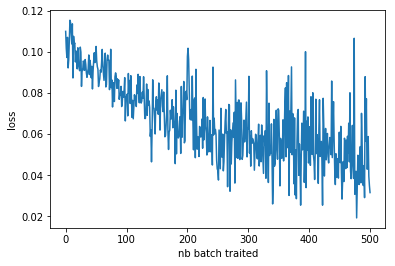

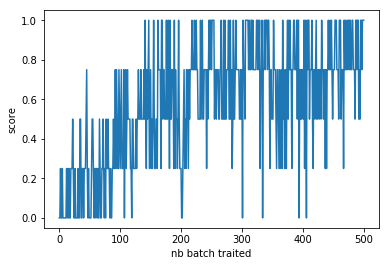

In [9]:
ml = nn.MSELoss()
ite = 500
opt = optim.SGD(simple_net.parameters(), lr=1e-3)

lossHisto = []
scoreHisto = []

for i,(x,yN) in enumerate(mnist_train_loader):
    if i > ite :
        break
    if i%(ite/10) == 0:
        print("Iteration", i)
    
    x = Variable(x.view(-1,784))
        
    y_onehot = torch.FloatTensor(*yN.size(), 10).zero_()
    y_onehot.scatter_(1, torch.unsqueeze(yN, 1), 1)
    y = Variable(y_onehot)
    
    f = simple_net.forward(x)
    loss = ml.forward(f, y)
    loss.backward()
    opt.step()
    
    lossHisto.append(loss.data.mean())
    ypred = torch.max(f, 1)[1]
    scoreHisto.append(torch.eq(ypred.data, yN).float().mean())
    
plt.plot(lossHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()
plt.plot(scoreHisto)
plt.ylabel('score')
plt.xlabel('nb batch traited')
plt.show()

In [10]:
for module in simple_net.modules():
    print(module, list(module.named_parameters()))
    for param in module.parameters():
        print(type(param.data), param.size())

Sequential(
  (0): Linear(in_features=784, out_features=312)
  (1): ReLU()
  (2): Linear(in_features=312, out_features=128)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=10)
) [('0.weight', Parameter containing:
-1.1196e-02  2.9830e-03  1.5520e-02  ...   3.7523e-02  1.5401e-02 -1.5257e-03
-2.0682e-02  2.9119e-02  2.2051e-02  ...  -1.3850e-02 -2.2326e-02  8.1088e-04
-2.4888e-02 -2.1796e-02  3.5583e-02  ...   2.8469e-02  1.9682e-02  3.4212e-02
                ...                   ⋱                   ...                
-1.3054e-02  1.4601e-02  1.9504e-02  ...   3.8670e-02  1.5405e-04  1.4910e-03
 3.6573e-02  3.4968e-03  2.7220e-02  ...  -1.5307e-02  3.5337e-02  1.5267e-02
-2.1541e-02  3.2591e-02 -1.9838e-02  ...  -1.6522e-02 -1.8378e-02  1.3681e-02
[torch.FloatTensor of size 312x784]
), ('0.bias', Parameter containing:
1.00000e-02 *
  0.7086
 -1.9910
  0.3346
  0.4027
  0.4357
 -0.8949
  0.4149
 -0.7078
  2.6090
 -2.1209
  2.6359
  1.0856
 -1.6375
  2.9623
  0.1599
  1.2304


## Modèle DEN

Basé sur les explications et algorithmes proposés par l'article

In [3]:
import pandas as pd

In [4]:
mnist_variation_train = pd.read_csv('./data/mnist_variation/mnist_all_background_images_rotation_normalized_train_valid.amat', delim_whitespace=True, header=None, names=[str(i) for i in range(784)] + ['label'])

In [5]:
mnist_variation_train_set = torch.utils.data.TensorDataset(
    torch.from_numpy(mnist_variation_train.as_matrix([str(i) for i in range(784)])).float(),
    torch.from_numpy(mnist_variation_train['label'].values).float(),
)
mnist_variation_train_set_loader = torch.utils.data.DataLoader(mnist_variation_train_set, batch_size=50, shuffle=True)


mnist_class_train_set = {c : [] for c in mnist_classes}

mnist_class_train_set

for i, (x, y) in enumerate(mnist_train_loader):
    mnist_class_train_set[y].append(x)

In [6]:
simple_net = nn.Sequential(nn.Linear(784, 312),
                           nn.ReLU(),
                           nn.Linear(312, 128),
                           nn.ReLU(),
                           nn.Linear(128, 1),
                           nn.ReLU())

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
Iteration 10000


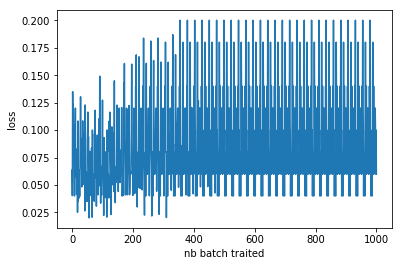

In [12]:
from algoDEN import DEN
import itertools

den = DEN(simple_net)

lossHisto = []
ite = 10000
for i,(x, y) in enumerate(itertools.cycle(mnist_variation_train_set_loader)):
    if i > ite :
        break
    if i%(ite/10) == 0:
        print("Iteration", i)

    x = Variable(x)
    y = Variable((y == 0).float())
    
    loss = den.trainFirst(x,y)
    
    if i%(10) == 0:
        lossHisto.append(loss.data.mean())

plt.plot(lossHisto)
plt.ylabel('loss')
plt.xlabel('nb batch traited')
plt.show()

Iteration 0
Iteration 50
Iteration 100
Iteration 150
Iteration 200
Iteration 250
Iteration 300
Iteration 350
Iteration 400
Iteration 450
Iteration 500


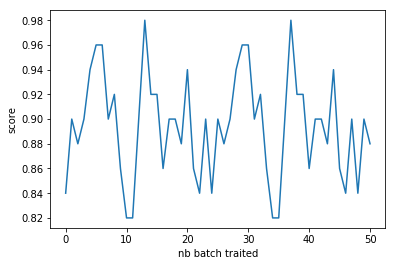

In [13]:
ite = 500

scoreHisto = []

for i,(x,y) in enumerate(itertools.cycle(mnist_variation_train_set_loader)):
    if i > ite :
        break
    if i%(ite/10) == 0:
        print("Iteration", i)
    
    x = Variable(x)
    y = Variable((y == 0).float())
    
    ypred = den.forward(x)
    
    if i%(10) == 0:
        scoreHisto.append(torch.eq(ypred.data, y.data).float().mean())
    

plt.plot(scoreHisto)
plt.ylabel('score')
plt.xlabel('nb batch traited')
plt.show()

In [50]:
param = [p for n, p in den.model.named_parameters() if "weight" in n]
param

[Parameter containing:
 -1.7103e-02 -6.4880e-03 -2.1688e-02  ...  -3.7179e-03 -1.4593e-02  1.4927e-02
 -7.9024e-01 -8.0769e-01 -7.6735e-01  ...  -6.4882e-01 -6.9612e-01 -6.6624e-01
 -1.1646e-01 -1.0026e-01 -8.4779e-02  ...  -6.5855e-02 -7.9337e-02 -1.2347e-01
                 ...                   ⋱                   ...                
 -6.6501e-02 -5.3744e-02 -1.0784e-01  ...  -4.6345e-02 -2.9209e-02 -5.5351e-03
 -7.3413e-01 -1.1148e-01 -3.5930e-02  ...  -2.9671e-01 -7.2458e-02  1.6449e-01
 -5.9253e-01 -4.4850e-01 -5.8458e-01  ...  -5.1653e-01 -4.2225e-01 -4.1438e-01
 [torch.FloatTensor of size 312x784], Parameter containing:
 -1.3132e-02  7.8394e-02 -2.2310e-02  ...  -6.3010e-02 -1.3170e+00 -4.4786e-01
  4.8245e-03 -5.5994e-02 -1.6066e-02  ...  -4.4173e-02 -3.0994e-01 -2.1106e-01
  1.7846e-02 -5.4565e-01 -9.3135e-02  ...   1.5663e-02 -5.3434e-01 -1.7303e+00
                 ...                   ⋱                   ...                
  1.5638e-02  4.3778e-02  9.4290e-02  ...  -9.31

In [63]:
param[0][0].data[0]

-0.017103124409914017

In [100]:
mask = list(range(len(param)))
mask[-1] = (param[-1].data > 0).float()
for i in reversed(range(len(param)-1)) :
    mask[i] = ((param[i].data > 0).float().t() * mask[i+1].max(0)[0]).t()

In [108]:
cpt = 0
for m in den.model.children():
    if [p for p in m.parameters()] != []:
        m.register_backward_hook(lambda module, grad_input, grad_output : grad_input * mask[cpt])
        cpt += 1

## Expérimentations

Basé sur le code fourni dans [la documentation de PyTorch](http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
losses = []

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    saving_loss = 0.0
    for i, data in enumerate(cifar10_train_loader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        saving_loss += loss.data[0]
        if i % 200 == 199:    # save every 200 mini-batches
            losses.append(saving_loss / 200)
            saving_loss = 0.0
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

plt.plot(losses)
plt.show()

In [ ]:
dataiter = iter(cifar10_test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(Variable(images))

In [ ]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [ ]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
net.cuda()

In [ ]:
inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())